In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from tqdm.auto import tqdm
tqdm.pandas()

pd.options.display.max_colwidth = None

sns.set_style('darkgrid')

import sys
sys.path.append('../')
from utils import viz
from utils.text import TextCleaner

D:\Users\Ritvik\Anaconda3\envs\ailab\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Data 
## Kaggle

In [2]:
data_kaggle = pd.read_json('../data/News_Category_Dataset_v2.json', lines=True)
print(data_kaggle.shape)
data_kaggle.head()

(200853, 6)


,category,headline,authors,link,short_description,date
0,CRIME,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,Andy McDonald,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",2018-05-26


In [3]:
data_kaggle['category'].unique()

array(['CRIME', 'ENTERTAINMENT', 'WORLD NEWS', 'IMPACT', 'POLITICS',
       'WEIRD NEWS', 'BLACK VOICES', 'WOMEN', 'COMEDY', 'QUEER VOICES',
       'SPORTS', 'BUSINESS', 'TRAVEL', 'MEDIA', 'TECH', 'RELIGION',
       'SCIENCE', 'LATINO VOICES', 'EDUCATION', 'COLLEGE', 'PARENTS',
       'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE', 'HEALTHY LIVING',
       'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST', 'FIFTY', 'ARTS',
       'WELLNESS', 'PARENTING', 'HOME & LIVING', 'STYLE & BEAUTY',
       'DIVORCE', 'WEDDINGS', 'FOOD & DRINK', 'MONEY', 'ENVIRONMENT',
       'CULTURE & ARTS'], dtype=object)

In [4]:
def generalize_kaggle(x):
    if x in ['BUSINESS', 'MONEY']:
        return 'business'
    if x in ['SCIENCE', 'TECH', 'ARTS', 'ARTS & CULTURE', 'COLLEGE', 'CULTURE & ARTS', 'EDUCATION']:
        return 'technology'
    if x in ['WELLNESS', 'TRAVEL', 'STYLE & BEAUTY', 'PARENTING', 'HEALTHY LIVING', 'HOME & LIVING', 'FOOD & DRINK', 'PARENTS', 'WEDDINGS', 'WOMEN', 'DIVORCE', 'RELIGION', 'STYLE', 'TASTE', 'FIFTY', 'ENVIRONMENT']:
        return 'lifestyle'
    if x in ['QUEER VOICES', 'BLACK VOICES', 'THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS', 'LATINO VOICES', 'IMPACT', 'MEDIA']:
        return 'world'
    if x in ['COMEDY', 'CRIME', 'WEIRD NEWS', 'GREEN', 'GOOD NEWS']:
        return 'hatke'
    else:
        return x.lower()

In [5]:
data_kaggle.category = data_kaggle.category.apply(generalize_kaggle)
data_kaggle['news'] = data_kaggle['headline'] + ' ' + data_kaggle['short_description']

data_kaggle = pd.concat([data_kaggle, pd.get_dummies(data_kaggle['category'])], axis=1)
data_kaggle.drop(['category', 'headline', 'authors', 'link', 'short_description', 'date'], axis=1, inplace=True)

data_kaggle.head()

,news,business,entertainment,hatke,lifestyle,politics,sports,technology,world
0,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America.",0,0,1,0,0,0,0,0
1,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song.,0,1,0,0,0,0,0,0
2,Hugh Grant Marries For The First Time At Age 57 The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,0,1,0,0,0,0,0,0
3,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,0,1,0,0,0,0,0,0
4,"Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",0,1,0,0,0,0,0,0


In [6]:
data_kaggle = data_kaggle.groupby('news').max().reset_index()
data_kaggle = data_kaggle.dropna(subset=['news']).reset_index(drop=True)
data_kaggle['source'] = 'kaggle'
print(len(data_kaggle))

200365


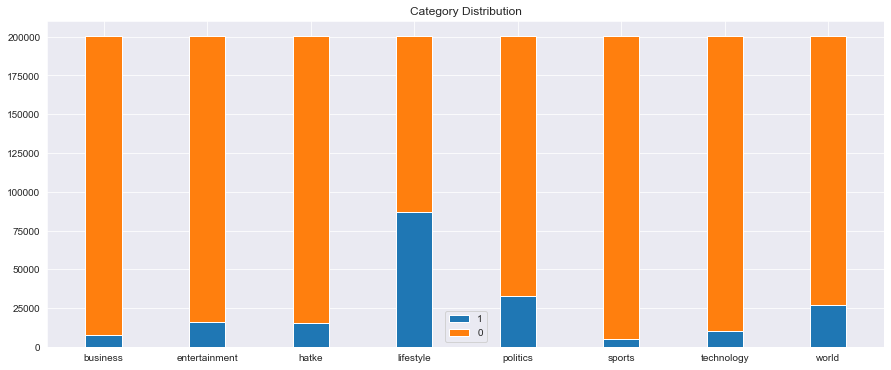

In [7]:
viz.target_multiclass_distribution(data_kaggle.drop(['news', 'source'], axis=1))

## Inshorts

In [8]:
data_inshorts = pd.read_csv('E:/Scrapped-Data/InshortsScraped.csv')
print(data_inshorts.shape)
data_inshorts.head()

(54617, 8)


,news,national,sports,world,politics,technology,entertainment,hatke
0,"""Modi Modi yes papa,"" Rashtriya Janata Dal pens poem on PM Modi",0,0,0,1,0,0,0
1,"""Powerphone"" Galaxy Note20 Ultra 5G to launch at Powerfest on 25 Aug",0,0,0,0,1,0,0
2,"""Powerphones"" - Samsung Galaxy Note20 | 20 Ultra 5G launched in India",0,0,0,0,1,0,0
3,#ACKOCatchTheLogo contest starts tomorrow,0,0,0,0,0,0,0
4,"#AyodhyaVerdict becomes world's top Twitter trend with over 630,000 tweets",1,0,1,0,1,0,0


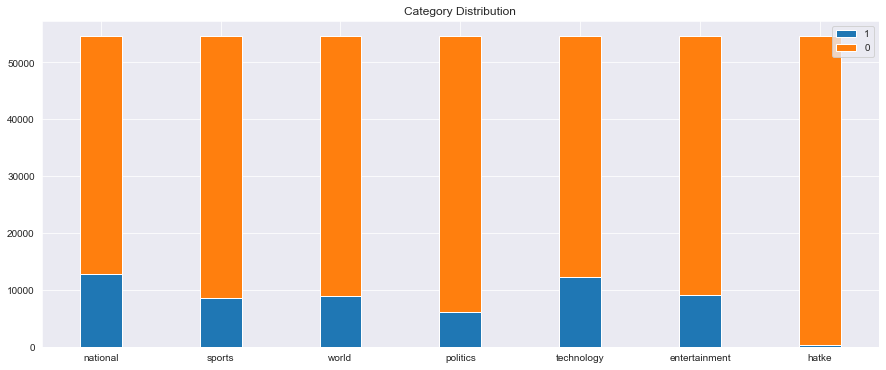

In [9]:
data_inshorts['source'] = 'inshorts'
viz.target_multiclass_distribution(data_inshorts.drop(['news', 'source'], axis=1))

## ANI

In [10]:
data_ani = pd.read_json('E:/Scrapped-Data/ANI.json')
print(data_ani.shape)
data_ani.head()

(251393, 4)


,headline,description,url,category
0,COVID-19 lockdown norms: Stand-alone grocery shops to operate betwee,"Kamrup (Assam) [India], July 5 (ANI): Assam State Disaster Management Authority on Sunday allowed all stand-alone grocery shops to operate between 11 am and 4 pm from July 6 to July 10 in Kamrup Metropolitan District.",/news/national/general-news/covid-19-lockdown-norms-stand-alone-grocery-shops-to-operate-between-11-am-and-4-pm-from-july-6-to-1020200705215827,national
1,"Ghaziabad factory fire: Magisterial inquiry ordered, Rs 4 lakh each","Ghaziabad (Uttar Pradesh) [India], July 5 (ANI): District Magistrate Ajay Shankar Pandey on Sunday said a magisterial inquiry has been ordered in candle factory fire incident in Ghaziabad and an ex-gratia of Rs 4 lakh each will be provided to the kin of the deceased.",/news/national/general-news/ghaziabad-factory-fire-magisterial-inquiry-ordered-rs-4-lakh-each-compensation-to-kin-of-deceased20200705215314,national
2,Kanpur Encounter: Investigation underway to ascertain whether uniden,"Kanpur (Uttar Pradesh) [India], July 5 (ANI): An investigation is underway to ascertain whether the unidentified vehicles seized by police are linked to the Kanpur encounter case in which 8 policemen lost their lives, said IGP Kanpur Mohit Agarwal on Sunday.",/news/national/general-news/kanpur-encounter-investigation-underway-to-ascertain-whether-unidentified-vehicles-linked-to-case-says-kanpur-igp20200705213359,national
3,Combating COVID-19: Kerala govt implements additional regulations re,"Thiruvananthapuram (Kerala) [India], July 5 (ANI): In the backdrop of increasing COVID-19 cases and in some cases where the sources are not identified, Kerala government has implemented certain additional regulations in the exercise of the powers conferred by of the Ker",/news/national/general-news/combating-covid-19-kerala-govt-implements-additional-regulations-regarding-kerala-epidemic-disease-ordinance-for-one-year20200705212951,national
4,Delhi: Rapid antigen detection test compulsory for high-risk group o,None,/news/national/general-news/delhi-rapid-antigen-detection-test-compulsory-for-high-risk-group-of-individuals20200705212717,national


In [11]:
data_ani.category.unique()

array(['national', 'world', 'business', 'sports', 'lifestyle',
       'entertainment', 'health', 'science', 'tech', 'environment'],
      dtype=object)

In [12]:
def generalize_ani(x):
    if x in ['tech', 'science']:
        return 'technology'
    if x in ['lifestyle', 'health', 'environment']:
        return 'lifestyle'
    return x

In [13]:
data_ani.category = data_ani.category.apply(generalize_ani)
data_ani['news'] = data_ani['headline'] + ' ' + data_ani['description']

data_ani = pd.concat([data_ani, pd.get_dummies(data_ani['category'])], axis=1)
data_ani.drop(['headline', 'description', 'url', 'category'], axis=1, inplace=True)

data_ani.head()

,news,business,entertainment,lifestyle,national,sports,technology,world
0,"COVID-19 lockdown norms: Stand-alone grocery shops to operate betwee Kamrup (Assam) [India], July 5 (ANI): Assam State Disaster Management Authority on Sunday allowed all stand-alone grocery shops to operate between 11 am and 4 pm from July 6 to July 10 in Kamrup Metropolitan District.",0,0,0,1,0,0,0
1,"Ghaziabad factory fire: Magisterial inquiry ordered, Rs 4 lakh each Ghaziabad (Uttar Pradesh) [India], July 5 (ANI): District Magistrate Ajay Shankar Pandey on Sunday said a magisterial inquiry has been ordered in candle factory fire incident in Ghaziabad and an ex-gratia of Rs 4 lakh each will be provided to the kin of the deceased.",0,0,0,1,0,0,0
2,"Kanpur Encounter: Investigation underway to ascertain whether uniden Kanpur (Uttar Pradesh) [India], July 5 (ANI): An investigation is underway to ascertain whether the unidentified vehicles seized by police are linked to the Kanpur encounter case in which 8 policemen lost their lives, said IGP Kanpur Mohit Agarwal on Sunday.",0,0,0,1,0,0,0
3,"Combating COVID-19: Kerala govt implements additional regulations re Thiruvananthapuram (Kerala) [India], July 5 (ANI): In the backdrop of increasing COVID-19 cases and in some cases where the sources are not identified, Kerala government has implemented certain additional regulations in the exercise of the powers conferred by of the Ker",0,0,0,1,0,0,0
4,NaN,0,0,0,1,0,0,0


In [14]:
data_ani = data_ani.groupby('news').max().reset_index()
data_ani = data_ani.dropna(subset=['news']).reset_index(drop=True)
data_ani['source'] = 'ani'
print(len(data_ani))

206007


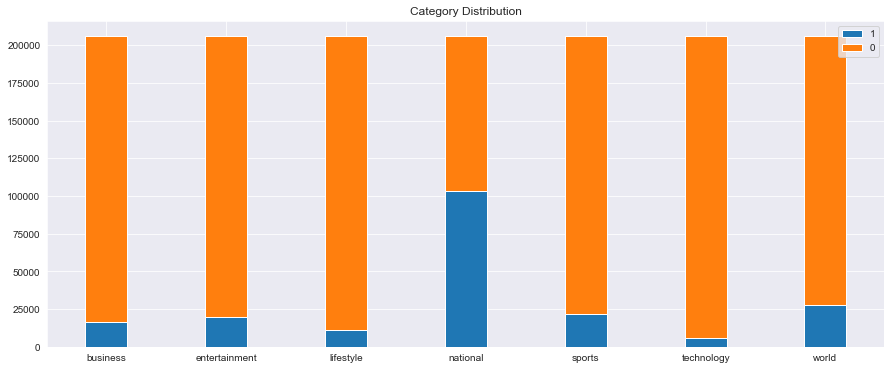

In [15]:
viz.target_multiclass_distribution(data_ani.drop(['news', 'source'], axis=1))

## India TV

In [16]:
data_indiatv = pd.read_csv('E:/Scrapped-Data/IndiaTV.csv')
print(data_indiatv.shape)
data_indiatv.head()

(344376, 4)


,headline,description,url,category
0,On track to drive in 10 products this year: Mercedes-Benz India,German luxury carmaker Mercedes-Benz on Wednesday said it remains on track to drive in ten models this year in India despite market conditions remaining tough due to coronavirus pandemic.,https://www.indiatvnews.com/auto/on-track-to-drive-in-10-products-this-year-mercedes-benz-india-626911,auto
1,"Hyundai Creta bookings cross 30,000 mark since March","Hyundai Motor India Ltd (HMIL) on Tuesday said the all-new version of Creta has crossed 30,000 booking mark since the launch of the model on March 16 this year.",https://www.indiatvnews.com/auto/hyundai-creta-bookings-cross-30000-mark-hyundai-motor-india-626658,auto
2,Mahindra & Mahindra launches BSVI-compliant ambulance Supro,"Mahindra & Mahindra on Tuesday said it has launched BSVI-compliant ambulance 'Supro' in two variants in the wake of coronavirus pandemic which has led to a rise in demand for such vehicles. Developed in-house on the company's popular Supro van platform, the vehicle is priced at Rs 6.94 lakh, the company said in a release.",https://www.indiatvnews.com/auto/mahindra-mahindra-launches-bsvi-compliant-ambulance-supro-626600,auto
3,"No sale, registration of BS-IV vehicle permitted in country: Supreme Court","No registration and sale of BS-IV vehicles is permitted across the country, the Supreme Court said on Monday while observing that pollution from such vehicles would be ""injurious"" and ""further burden on human health"".",https://www.indiatvnews.com/auto/no-sale-registration-of-bs-iv-vehicle-permitted-in-country-supreme-court-626462,auto
4,"Porsche's flagship Panamera 10 Years Edition launched in India, priced at Rs 1.6 crore","Luxury sports carmaker Porsche India on Monday said it has launched Panamera 4 10 Years Edition priced at Rs 1.6 crore (ex-showroom). The new edition is being introduced to commemorate ten years of launch of Panamera brand in the country, Porsche India said in a statement.",https://www.indiatvnews.com/auto/porsche-panamera-10-years-edition-launched-in-india-priced-at-rs-1-6-crore-626326,auto


In [17]:
data_indiatv.category.unique()

array(['auto', 'brandcontent', 'business', 'crime', 'education',
       'entertainment', 'fyi', 'health', 'india', 'jobs', 'lifestyle',
       'politics', 'science', 'sports', 'technology', 'trending', 'world'],
      dtype=object)

In [18]:
def generalize_indiatv(x):
    if x in ['auto', 'brandcontent', 'jobs']:
        return 'business'
    if x in ['crime', 'india']:
        return 'national'
    if x in ['education', 'science']:
        return 'technology'
    if x in ['fyi', 'trending']:
        return 'hatke'
    if x in ['health']:
        return 'lifestyle'
    return x

In [19]:
data_indiatv.category = data_indiatv.category.apply(generalize_indiatv)
data_indiatv['news'] = data_indiatv['headline'] + ' ' + data_indiatv['description']

data_indiatv = pd.concat([data_indiatv, pd.get_dummies(data_indiatv['category'])], axis=1)
data_indiatv.drop(['headline', 'description', 'url', 'category'], axis=1, inplace=True)

data_indiatv.head()

,news,business,entertainment,hatke,lifestyle,national,politics,sports,technology,world
0,On track to drive in 10 products this year: Mercedes-Benz India German luxury carmaker Mercedes-Benz on Wednesday said it remains on track to drive in ten models this year in India despite market conditions remaining tough due to coronavirus pandemic.,1,0,0,0,0,0,0,0,0
1,"Hyundai Creta bookings cross 30,000 mark since March Hyundai Motor India Ltd (HMIL) on Tuesday said the all-new version of Creta has crossed 30,000 booking mark since the launch of the model on March 16 this year.",1,0,0,0,0,0,0,0,0
2,"Mahindra & Mahindra launches BSVI-compliant ambulance Supro Mahindra & Mahindra on Tuesday said it has launched BSVI-compliant ambulance 'Supro' in two variants in the wake of coronavirus pandemic which has led to a rise in demand for such vehicles. Developed in-house on the company's popular Supro van platform, the vehicle is priced at Rs 6.94 lakh, the company said in a release.",1,0,0,0,0,0,0,0,0
3,"No sale, registration of BS-IV vehicle permitted in country: Supreme Court No registration and sale of BS-IV vehicles is permitted across the country, the Supreme Court said on Monday while observing that pollution from such vehicles would be ""injurious"" and ""further burden on human health"".",1,0,0,0,0,0,0,0,0
4,"Porsche's flagship Panamera 10 Years Edition launched in India, priced at Rs 1.6 crore Luxury sports carmaker Porsche India on Monday said it has launched Panamera 4 10 Years Edition priced at Rs 1.6 crore (ex-showroom). The new edition is being introduced to commemorate ten years of launch of Panamera brand in the country, Porsche India said in a statement.",1,0,0,0,0,0,0,0,0


In [20]:
data_indiatv = data_indiatv.groupby('news').max().reset_index()
data_indiatv = data_indiatv.dropna(subset=['news']).reset_index(drop=True)
data_indiatv['source'] = 'indiatv'
print(len(data_indiatv))

343410


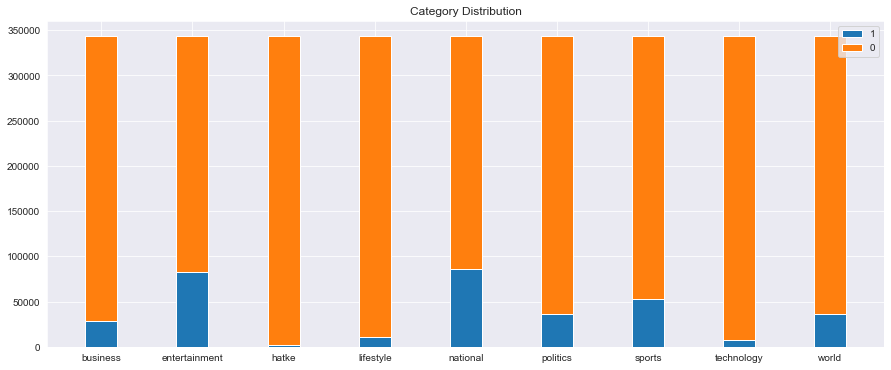

In [21]:
viz.target_multiclass_distribution(data_indiatv.drop(['news', 'source'], axis=1))

## Janta Ka Reporter

In [22]:
data_jantakareporter = pd.read_json('E:/Scrapped-Data/JantaKaReporter.json')
print(data_jantakareporter.shape)
data_jantakareporter.head()

(50037, 3)


,headline,url,category
0,"After reported occupation by Chinese troops, now Nepal’s parliament clears map...",http://www.jantakareporter.com/india/after-reported-occupation-by-chinese-troops-now-nepals-parliament-clears-map-laying-claims-on-indian-territory-india-reacts-with-disappointment/293845/,World
1,“Need prayers”: Former Pakistani cricketer Shahid Afridi tests positive for COVID-19,http://www.jantakareporter.com/sports/need-prayers-former-pakistani-cricketer-shahid-afridi-tests-positive-for-covid-19/293765/,World
2,Nepal Police open fire at Indian farmers at Indo-Nepal border; 1...,http://www.jantakareporter.com/world/nepal-police-open-fire-at-indian-farmers-at-indo-nepal-border-1-indian-national-killed/293662/,World
3,"Kerala man, who live streamed his sexual encounter with girl, arrested",http://www.jantakareporter.com/india/kerala-man-sex-facebook-live/149546/,Culture
4,France says its military forces killed Al-Qaeda chief in north Africa...,http://www.jantakareporter.com/world/france-says-its-military-forces-killed-al-qaeda-chief-in-north-africa-abdelmalek-droukdel/292885/,World


In [23]:
data_jantakareporter.category.unique()

array(['World', 'Culture', 'Education', 'Sports', 'Politics',
       'Entertainment', 'Science', 'Society', 'In Pictures', 'Technology',
       'Social Media Buzz', 'India'], dtype=object)

In [24]:
def generalize_jantakareporter(x):
    if x in ['Culture', 'India']:
        return 'national'
    if x in ['Education', 'Science']:
        return 'technology'
    if x in ['In Pictures', 'Social Media Buzz']:
        return 'hatke'
    if x in ['Society']:
        return 'lifestyle'
    return x.lower()

In [25]:
data_jantakareporter.category = data_jantakareporter.category.apply(generalize_jantakareporter)
data_jantakareporter['news'] = data_jantakareporter['headline']

data_jantakareporter = pd.concat([data_jantakareporter, pd.get_dummies(data_jantakareporter['category'])], axis=1)
data_jantakareporter.drop(['headline', 'url', 'category'], axis=1, inplace=True)

data_jantakareporter.head()

,news,entertainment,hatke,lifestyle,national,politics,sports,technology,world
0,"After reported occupation by Chinese troops, now Nepal’s parliament clears map...",0,0,0,0,0,0,0,1
1,“Need prayers”: Former Pakistani cricketer Shahid Afridi tests positive for COVID-19,0,0,0,0,0,0,0,1
2,Nepal Police open fire at Indian farmers at Indo-Nepal border; 1...,0,0,0,0,0,0,0,1
3,"Kerala man, who live streamed his sexual encounter with girl, arrested",0,0,0,1,0,0,0,0
4,France says its military forces killed Al-Qaeda chief in north Africa...,0,0,0,0,0,0,0,1


In [26]:
data_jantakareporter = data_jantakareporter.groupby('news').max().reset_index()
data_jantakareporter = data_jantakareporter.dropna(subset=['news']).reset_index(drop=True)
data_jantakareporter['source'] = 'jantakareporter'
print(len(data_jantakareporter))

31083


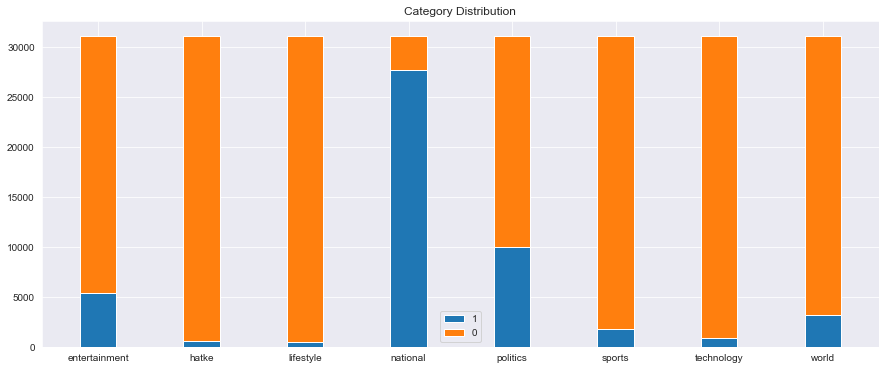

In [27]:
viz.target_multiclass_distribution(data_jantakareporter.drop(['news', 'source'], axis=1))

## OpIndia

In [28]:
data_opindia = pd.read_json('E:/Scrapped-Data/OpIndiaComplete.json')
print(data_opindia.shape)
data_opindia.head()

(20540, 3)


,headline,url,category
0,Why China needs ‘Bharat ke tukde’ to become a superpower,https://www.opindia.com/2020/06/china-bharat-ke-tukde-superpower-galwan-valley-ladakh-xi-jinping-narendra-modi/,Politics
1,"‘Remember 1962’: Sharad Pawar slams Rahul Gandhi for his ‘Modi surrendered Indian territory’ remark, says Ladakh clash was not a govt failure",https://www.opindia.com/2020/06/sharad-pawar-slams-rahul-gandhi-lac-clash-china-remember-1962-aksai-sin/,Politics
2,Rajiv Gandhi Foundation received donations from a foundation that was partners with Huawei and received donations from Qatar Foundation,https://www.opindia.com/2020/06/rajiv-gandhi-foundation-bharti-foundation-huawi-qatar-foundation-fiscal-year-19/,Politics
3,"Aam Aadmi Party claims credit for 10,000-bed coronavirus facility in Delhi built by ITBP under union home ministry, mocks Modi government",https://www.opindia.com/2020/06/aap-takes-credit-for-coronavirus-facility-built-by-itbp-under-union-centre/,Politics
4,"Popular Pakistani troll reveals how he makes sure PM Modi doesn’t win any Twitter polls, how anti-India propaganda is organised and furthered",https://www.opindia.com/2020/06/al-jazeera-documentary-pakistan-anti-india-propaganda-twitter/,Politics


In [29]:
data_opindia.category.unique()

array(['Politics', 'Opinions', 'Government and Policy', 'Social Media',
       'Economy and Finance', 'Specials', 'Crime', 'Entertainment',
       'Media', 'Variety', 'Sports', 'Fact-Check',
       'Political History of India', 'Law'], dtype=object)

In [30]:
def generalize_opindia(x):
    if x in ['Crime']:
        return 'national'
    if x in ['Opinions', 'Government and Policy', 'Political History of India', 'Law', 'Media']:
        return 'politics'
    if x in ['Social Media', 'Specials', 'Variety', 'Fact-Check']:
        return 'hatke'
    if x in ['Economy and Finance']:
        return 'business'
    return x.lower()

In [31]:
data_opindia.category = data_opindia.category.apply(generalize_opindia)
data_opindia['news'] = data_opindia['headline']

data_opindia = pd.concat([data_opindia, pd.get_dummies(data_opindia['category'])], axis=1)
data_opindia.drop(['headline', 'url', 'category'], axis=1, inplace=True)

data_opindia.head()

,news,business,entertainment,hatke,national,politics,sports
0,Why China needs ‘Bharat ke tukde’ to become a superpower,0,0,0,0,1,0
1,"‘Remember 1962’: Sharad Pawar slams Rahul Gandhi for his ‘Modi surrendered Indian territory’ remark, says Ladakh clash was not a govt failure",0,0,0,0,1,0
2,Rajiv Gandhi Foundation received donations from a foundation that was partners with Huawei and received donations from Qatar Foundation,0,0,0,0,1,0
3,"Aam Aadmi Party claims credit for 10,000-bed coronavirus facility in Delhi built by ITBP under union home ministry, mocks Modi government",0,0,0,0,1,0
4,"Popular Pakistani troll reveals how he makes sure PM Modi doesn’t win any Twitter polls, how anti-India propaganda is organised and furthered",0,0,0,0,1,0


In [32]:
data_opindia = data_opindia.groupby('news').max().reset_index()
data_opindia = data_opindia.dropna(subset=['news']).reset_index(drop=True)
data_opindia['source'] = 'opindia'
print(len(data_opindia))

15080


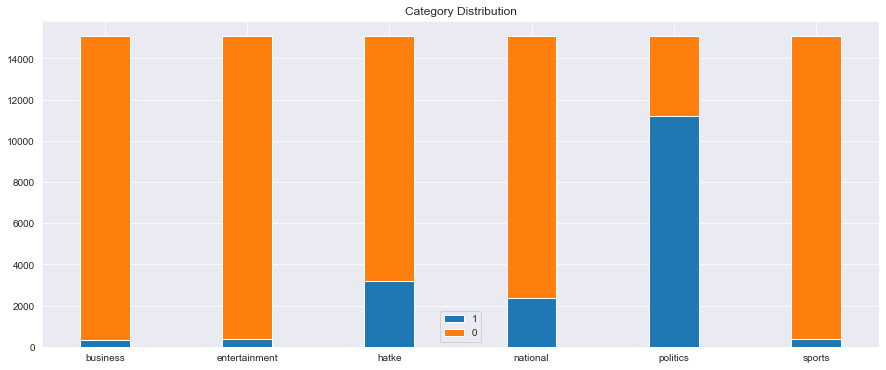

In [33]:
viz.target_multiclass_distribution(data_opindia.drop(['news', 'source'], axis=1))

## Post Card

In [34]:
data_postcard = pd.read_json('E:/Scrapped-Data/PostcardNews.json')
print(data_postcard.shape)
data_postcard.head()

(8632, 3)


,headline,url,category
0,Rebirth of Education: Will Digitization Remain an Option or Become a Necessity?,https://postcard.news/rebirth-of-education/,Opinion
1,Namo’s Standby Appeal To The Citizens Of India!!,https://postcard.news/namos-standby-appeal-to-the-citizens-of-india/,Nationalism
2,"Days Ago Congis and Left Liberals Had Become Grid Experts, And Now They Have Turned Hydroxychloroquine Experts!",https://postcard.news/fake-news-and-fear-mongering-by-congress-and-communist-leaders/,Nationalism
3,The Chilling Story of Encounter That Took Place Yesterday! Know How Our Brave hearts Fought The Terrorist In A Close Quarter Battle!,https://postcard.news/encounter-at-kupwara/,Nationalism
4,A Complete Lockdown Of 21 Days- For Ourselves; For Our Own Future! Highlights Of Prime Minister Modi’s Address To The Nation!,https://postcard.news/india-under-lockdown/,Nationalism


In [35]:
data_postcard.category.unique()

array(['Opinion', 'Nationalism', 'Culture', 'Politics', None, 'Economy',
       'Satire'], dtype=object)

In [36]:
def generalize_postcard(x):
    if x in ['Culture']:
        return 'national'
    if x in ['Opinion', 'Nationalism', 'Politics']:
        return 'politics'
    if x in ['Social Media', 'Specials', 'Variety', 'Fact-Check']:
        return 'hatke'
    if x in ['Economy']:
        return 'business'
    return 'hatke'

In [37]:
data_postcard.category = data_postcard.category.apply(generalize_postcard)
data_postcard['news'] = data_postcard['headline']

data_postcard = pd.concat([data_postcard, pd.get_dummies(data_postcard['category'])], axis=1)
data_postcard.drop(['headline', 'url', 'category'], axis=1, inplace=True)

data_postcard.head()

,news,business,hatke,national,politics
0,Rebirth of Education: Will Digitization Remain an Option or Become a Necessity?,0,0,0,1
1,Namo’s Standby Appeal To The Citizens Of India!!,0,0,0,1
2,"Days Ago Congis and Left Liberals Had Become Grid Experts, And Now They Have Turned Hydroxychloroquine Experts!",0,0,0,1
3,The Chilling Story of Encounter That Took Place Yesterday! Know How Our Brave hearts Fought The Terrorist In A Close Quarter Battle!,0,0,0,1
4,A Complete Lockdown Of 21 Days- For Ourselves; For Our Own Future! Highlights Of Prime Minister Modi’s Address To The Nation!,0,0,0,1


In [38]:
data_postcard = data_postcard.groupby('news').max().reset_index()
data_postcard = data_postcard.dropna(subset=['news']).reset_index(drop=True)
data_postcard['source'] = 'postcard'
print(len(data_postcard))

8623


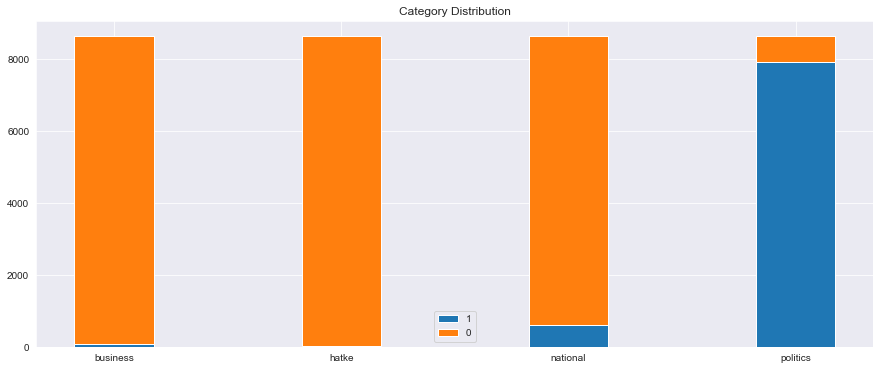

In [39]:
viz.target_multiclass_distribution(data_postcard.drop(['news', 'source'], axis=1))

## Swarajya

In [40]:
data_swarajya = pd.read_json('E:/Scrapped-Data/Swarajya.json')
print(data_swarajya.shape)
data_swarajya.head()

(45728, 3)


,headline,url,slug
0,"Jio Hits Back At PayTM, Says Digital Payment Major Blaming Telcos To Hide Its Own Security Flaws",https://swarajyamag.com/insta/jio-hits-back-at-paytm-says-digital-payment-major-blaming-telcos-to-hide-its-own-security-flaws,insta/jio-hits-back-at-paytm-says-digital-payment-major-blaming-telcos-to-hide-its-own-security-flaws
1,"Here’s Why China’s Bigger Size, Economy And Military Need Not Make India Circumspect, Time Now To Call The Bully’s Bluff",https://swarajyamag.com/world/heres-why-chinas-bigger-size-economy-and-military-need-not-make-india-circumspect-time-now-to-call-the-bullys-bluff,world/heres-why-chinas-bigger-size-economy-and-military-need-not-make-india-circumspect-time-now-to-call-the-bullys-bluff
2,"Delhi: Amid Surge In Covid-19 Cases, Hospitals Ordered To Recall Medical Staff On Leave",https://swarajyamag.com/insta/delhi-amid-surge-in-covid-19-cases-hospitals-ordered-to-recall-medical-staff-on-leave,insta/delhi-amid-surge-in-covid-19-cases-hospitals-ordered-to-recall-medical-staff-on-leave
3,‘Mischievous Interpretation’: PMO Responds To Criticism Over PM Modi’s Remarks On Ladakh Face-Off,https://swarajyamag.com/insta/mischievous-interpretation-pmo-responds-to-criticism-over-pm-modis-remarks-on-ladakh-face-off,insta/mischievous-interpretation-pmo-responds-to-criticism-over-pm-modis-remarks-on-ladakh-face-off
4,"Salman Khan’s Being Human Is A Money Laundering Hub, Alleges Dabangg Director Abhinav Kashyap",https://swarajyamag.com/insta/salman-khans-being-human-is-a-money-laundering-hub-alleges-dabangg-director-abhinav-kashyap,insta/salman-khans-being-human-is-a-money-laundering-hub-alleges-dabangg-director-abhinav-kashyap


In [41]:
data_swarajya.slug.apply(lambda x: x.split('/')[0]).unique()

array(['insta', 'world', 'videos', 'politics', 'ideas', 'culture',
       'news-brief', 'economy', 'infrastructure', 'defence',
       'announcements', 'business', 'science', 'technology', 'analysis',
       'news-headlines', 'blogs', 'commentary', 'books', 'sports',
       'health', 'magazine', 'media', 'from-the-archives', 'updates',
       'heritage', 'columns', 'movies', 'economics', 'obit', 'reviews',
       'lite', 'current-affairs', 'agenda-2014', 'people', 'sponsored',
       'editors-pick', 'elsewhere', 'podcasts', 'food', 'fiction',
       'security', 'minibooks', 'featured', 'india-ideas-conclave-2014',
       'smart-cities', 'tech', 'india-conference-at-harvard', 'cartoons',
       'foreign-affairs', 'punctuations', 'madurai-sultanate', 'longform',
       'world-on-wednesday', 'the-bar', 'mindsnack', 'election-2012',
       'my-name-is-category', 'elections-2011', 'voice-of-readers',
       'the-right-people', 'elections-with-5forty3'], dtype=object)

In [42]:
def generalize_swarajya(x):
    if x in ['culture', 'news-brief', 'infrastructure', 'defence', 'analysis', 'news-headlines', 'from-the-archives', 'updates', 'heritage', 'columns', 'agenda-2014', 'people', 'security', 'india-ideas-conclave-2014', 'smart-cities', 'india-conference-at-harvard', 'foreign-affairs', 'punctuations', 'madurai-sultanate', 'longform', 'elections-2011', 'voice-of-readers', 'the-right-people', 'elections-with-5forty3']:
        return 'national'
    if x in ['Opinion', 'Nationalism', 'Politics']:
        return 'politics'
    if x in ['insta', 'videos', 'announcements', 'blogs', 'commentary', 'reviews', 'lite', 'current-affairs', 'sponsored','editors-pick', 'elsewhere', 'podcasts', 'featured', 'my-name-is-category']:
        return 'hatke'
    if x in ['ideas', 'science', 'technology', 'tech']:
        return 'technology'
    if x in ['economy', 'economics']:
        return 'business'
    if x in ['books', 'health', 'magazine', 'obit', 'food', 'fiction', 'minibooks', 'cartoons', 'the-bar', 'mindsnack']:
        return 'lifestyle'
    if x in ['media', 'world-on-wednesday', 'election-2012']:
        return 'world'
    if x in ['movies']:
        return 'entertainment'
    return x

In [43]:
data_swarajya['category'] = data_swarajya.slug.apply(lambda x: x.split('/')[0]).apply(generalize_swarajya)
data_swarajya['news'] = data_swarajya['headline']

data_swarajya = pd.concat([data_swarajya, pd.get_dummies(data_swarajya['category'])], axis=1)
data_swarajya.drop(['headline', 'url', 'slug', 'category'], axis=1, inplace=True)

data_swarajya.head()

,news,business,entertainment,hatke,lifestyle,national,politics,sports,technology,world
0,"Jio Hits Back At PayTM, Says Digital Payment Major Blaming Telcos To Hide Its Own Security Flaws",0,0,1,0,0,0,0,0,0
1,"Here’s Why China’s Bigger Size, Economy And Military Need Not Make India Circumspect, Time Now To Call The Bully’s Bluff",0,0,0,0,0,0,0,0,1
2,"Delhi: Amid Surge In Covid-19 Cases, Hospitals Ordered To Recall Medical Staff On Leave",0,0,1,0,0,0,0,0,0
3,‘Mischievous Interpretation’: PMO Responds To Criticism Over PM Modi’s Remarks On Ladakh Face-Off,0,0,1,0,0,0,0,0,0
4,"Salman Khan’s Being Human Is A Money Laundering Hub, Alleges Dabangg Director Abhinav Kashyap",0,0,1,0,0,0,0,0,0


In [44]:
data_swarajya = data_swarajya.groupby('news').max().reset_index()
data_swarajya = data_swarajya.dropna(subset=['news']).reset_index(drop=True)
data_swarajya['source'] = 'swarajya'
print(len(data_swarajya))

45713


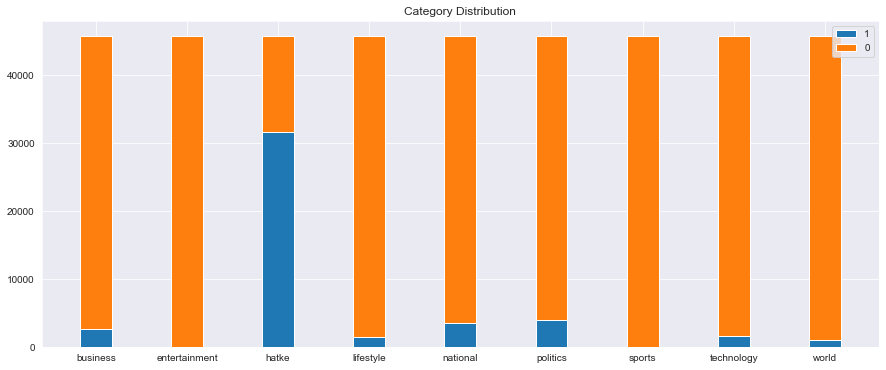

In [45]:
viz.target_multiclass_distribution(data_swarajya.drop(['news', 'source'], axis=1))

## TFI

In [46]:
data_tfi = pd.read_json('E:/Scrapped-Data/TFIPost.json')
print(data_tfi.shape)
data_tfi.head()

(102864, 3)


,title,url,category
0,Nepal has banned Indian Media but the damage is already done as people question KP Oli and Hou Yanqi,https://tfipost.com/2020/07/nepal-has-banned-indian-media-but-the-damage-is-already-done-as-people-question-kp-oli-and-hou-yanqi/,Politics
1,UP Police sends a clear message to Mafias and their sponsors with the encounter of Vikas Dubey,https://tfipost.com/2020/07/up-police-sends-a-message-to-mafias-and-their-sponsors-with-the-encounter-of-vikas-dubey/,Politics
2,China’s dream of a Pearl River Delta Megacity is Hong Kong’s nightmare,https://tfipost.com/2020/07/chinas-dream-of-a-pearl-river-delta-megacity-is-hong-kongs-nightmare/,Politics
3,"‘Kulbhushan does not want to file review petition,’ Pakistan is at it again, tries to flout ICJ ruling",https://tfipost.com/2020/07/kulbhushan-does-not-want-to-file-review-petition-pakistan-is-at-it-again-tries-to-flout-icj-ruling/,Politics
4,"‘We urge you not to remove us,’ Huawei panics as UK steps up phasing out process",https://tfipost.com/2020/07/we-urge-you-not-to-remove-us-huawei-panics-as-uk-steps-up-phasing-out-process/,Politics


In [47]:
data_tfi.category.unique()

array(['Politics', 'Defense', 'Lounge', 'Geopolitics', 'Economy',
       'Knowledge', 'Newswire'], dtype=object)

In [48]:
def generalize_tfi(x):
    if x in ['Defense', 'Newswire']:
        return 'national'
    if x in ['Politics', 'Geopolitics', 'Politics']:
        return 'politics'
    if x in ['Lounge']:
        return 'entertainment'
    if x in ['Economy']:
        return 'business'
    return 'hatke'

In [49]:
data_tfi.category = data_tfi.category.apply(generalize_tfi)
data_tfi['news'] = data_tfi['title']

data_tfi = pd.concat([data_tfi, pd.get_dummies(data_tfi['category'])], axis=1)
data_tfi.drop(['title', 'url', 'category'], axis=1, inplace=True)

data_tfi.head()

,news,business,entertainment,hatke,national,politics
0,Nepal has banned Indian Media but the damage is already done as people question KP Oli and Hou Yanqi,0,0,0,0,1
1,UP Police sends a clear message to Mafias and their sponsors with the encounter of Vikas Dubey,0,0,0,0,1
2,China’s dream of a Pearl River Delta Megacity is Hong Kong’s nightmare,0,0,0,0,1
3,"‘Kulbhushan does not want to file review petition,’ Pakistan is at it again, tries to flout ICJ ruling",0,0,0,0,1
4,"‘We urge you not to remove us,’ Huawei panics as UK steps up phasing out process",0,0,0,0,1


In [50]:
data_tfi = data_tfi.groupby('news').max().reset_index()
data_tfi = data_tfi.dropna(subset=['news']).reset_index(drop=True)
data_tfi['source'] = 'tfi'
print(len(data_tfi))

102511


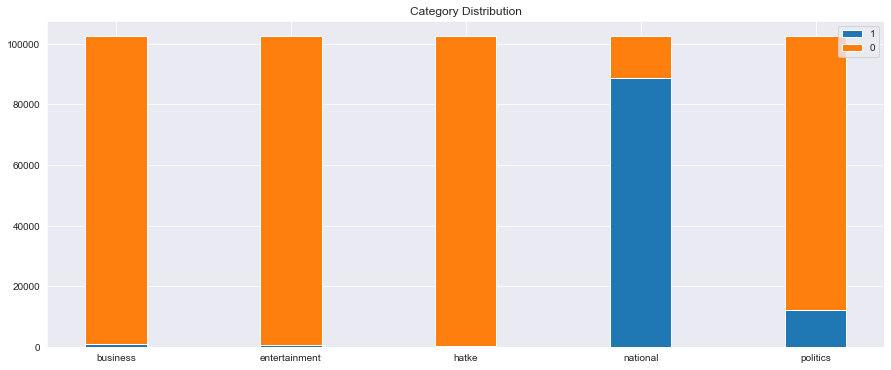

In [51]:
viz.target_multiclass_distribution(data_tfi.drop(['news', 'source'], axis=1))

## The Week

In [52]:
data_theweek = pd.read_json('E:/Scrapped-Data/TheWeek.json')
print(data_theweek.shape)
data_theweek.head()

(28837, 4)


,title,description,url,section
0,,"Modi said the challenge would create an ""Aatmanirbhar App Ecosystem""",https://www.theweek.in/news/india/2020/07/04/pm-modi-launches-aatma-nirbhar-bharat-app-innovation-challenge.html,India
1,Civil society pushes for state-level migration policies; develops framework,"MoUs between states, effective intervention by the Centre recommended",https://www.theweek.in/news/india/2020/07/04/civil-society-pushes-for-state-level-migration-policies-develops-framework.html,India
2,Kanpur encounter: Slain policemen cremated with full honours,Financial aid & govt job announced by the state govt will be given to the...,https://www.theweek.in/news/india/2020/07/04/kanpur-encounter-slain-policemen-cremated-with-full-honours.html,India
3,CPI(M) alleges ICMR fast tracking COVID vaccine for PM announcement on I-Day,'But...scientific advances can never be 'made to order' Yechury tweeted,https://www.theweek.in/news/india/2020/07/04/cpim-alleges-icmr-fast-tracking-covid-vaccine-for-pm-announcement-on-i-day.html,India
4,,The ambulance reached the patient's residence after a delay of two hours,https://www.theweek.in/news/india/2020/07/04/covid-19-patient-dies-on-road-in-bengaluru-waiting-for-ambulance.html,India


In [53]:
data_theweek.section.unique()

array(['India', 'World', 'Business', 'Sports', 'Sci/Tech',
       'Entertainment', 'Health',
       'Google to offer WiFi Stations, YouTube Go and more in India',
       'Greenery can reduce risk for cardiovascular disease, says research',
       'New model: Universe may be an expanding bubble in space',
       'Gut bacteria can protect against high blood pressure ',
       'What brain research says about full concentration',
       "Dads' postnatal depression can lead to depression in teenage daughters: Study",
       'Kidney disease risk tied to soda, sweetened drinks',
       'Want to quit smoking? Cutting back on drinking could help',
       'How exercise helps you lose weight',
       'Sea-weed eating microbes used to develop sustainable plastics  ',
       'WHO lays out recommendations to save newborns',
       'Modi govt mulls making prepaid electricity meters mandatory in 3 years',
       'As smartphone sales decline, feature phones rediscover their mojo',
       "IIT Kharagpur

In [54]:
theweek_cat = ['India', 'World', 'Business', 'Sports', 'Sci/Tech', 'Entertainment', 'Health']
data_theweek = data_theweek[data_theweek['section'].isin(theweek_cat)]
len(data_theweek)

28137

In [55]:
def generalize_theweek(x):
    if x in ['India']:
        return 'national'
    if x in ['Health']:
        return 'lifestyle'
    if x in ['Sci/Tech']:
        return 'technology'
    return x.lower()

In [56]:
data_theweek['category'] = data_theweek.section.apply(generalize_theweek)
data_theweek['news'] = data_theweek['title'] + ' ' + data_theweek['description']

data_theweek = pd.concat([data_theweek, pd.get_dummies(data_theweek['category'])], axis=1)
data_theweek.drop(['title', 'url', 'category', 'section', 'description'], axis=1, inplace=True)

data_theweek.head()

,news,business,entertainment,lifestyle,national,sports,technology,world
0,"Modi said the challenge would create an ""Aatmanirbhar App Ecosystem""",0,0,0,1,0,0,0
1,"Civil society pushes for state-level migration policies; develops framework MoUs between states, effective intervention by the Centre recommended",0,0,0,1,0,0,0
2,Kanpur encounter: Slain policemen cremated with full honours Financial aid & govt job announced by the state govt will be given to the...,0,0,0,1,0,0,0
3,CPI(M) alleges ICMR fast tracking COVID vaccine for PM announcement on I-Day 'But...scientific advances can never be 'made to order' Yechury tweeted,0,0,0,1,0,0,0
4,The ambulance reached the patient's residence after a delay of two hours,0,0,0,1,0,0,0


In [57]:
data_theweek = data_theweek.groupby('news').max().reset_index()
data_theweek = data_theweek.dropna(subset=['news']).reset_index(drop=True)
data_theweek['source'] = 'theweek'
print(len(data_theweek))

28031


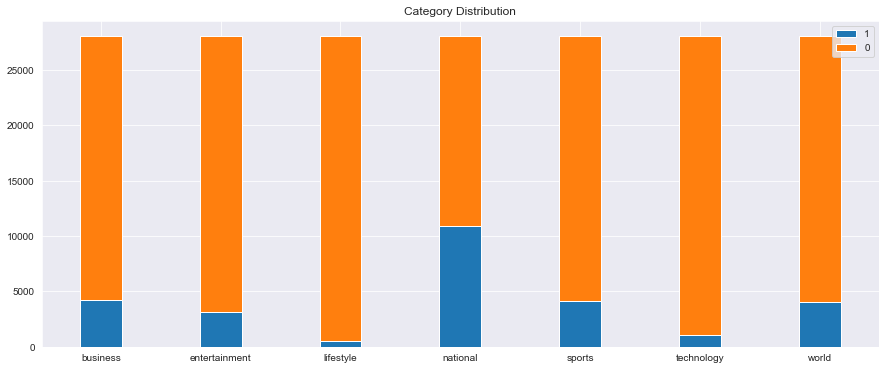

In [58]:
viz.target_multiclass_distribution(data_theweek.drop(['news', 'source'], axis=1))

## The Wire

In [59]:
data_thewire = pd.read_json('E:/Scrapped-Data/TheWire.json')
print(data_thewire.shape)
data_thewire.head()

(68717, 4)


,title,excerpt,categories,tags
0,"Nagaland Bans Sale, Consumption of Dog Meat",The government also decided to ban commercial import and trading of pigs with immediate effect.,"[Food, Government]","[dog meat ban, dog meat ban nagaland, dog meat nagaland, Latest headlines, latest news, Nagaland, nagaland ban on dog meat, nagaland dog, nagaland dog meat, nagaland dog meat ban, News, top headlines, Top News, top stories, yulin festival]"
1,Interview: How Kerala Contained Its Coronavirus Epidemic,"Vijay Sakhare is the commissioner of police in Kochi, Kerala, and the chief architect of Kerala's triple lock strategy as special officer for COVID-19 in Kasaragod district.","[Government, Health]","[breaking headlines today, containment zones, coronavirus vaccine, covid 19, india coronavirus lockdown, Interview, kasaragod, Kerala, latest news, new coronavirus, Novel coronavirus, Swaraksha Kasaragode, Top News, triple lock strategy, Vijay Sakhare]"
2,"Small-Time Politician, Real-Estate Businessman, Gangster: Who Is Vikas Dubey?",Dubey's men shot dead eight police personnel in Kanpur on Friday.,[Politics],"[Vikas Dubey, vikas dubey elections, vikas dubey house, vikas dubey murder, vikas dubey murder accusation, vikas dubey politician, vikas dubey politics, vikas dubey real estate]"
3,Backstory: ‘Emergency’ by Any Other Name Cuts as Deep,A fortnightly column from The Wire's public editor.,"[Government, Media, Rights]","[Amit Shah, BJP, coronavirus, coronavirus crisis, covid 19, covid 19 crisis, Emergency, india press freedom, Indira Gandhi, Latest headlines, latest news, Narendra Modi, News, press freedom, RSS, Sathankulam, Thoothukudi, thoothukudi custodial death, thoothukudi custodial torture, thoothukudi police violence, top headlines, Top News, top stories, undeclared emergency]"
4,Bihar: Eight More Killed After Being Struck by Lightning,More than 100 people have died due to lightning strikes in the state in the last week.,[Government],"[bihar lightning, bihar lightning death, death by lightning, death by lightning in UP, lightning death bihar, lightning deaths, lightning strike, lightning strike death, Lightning strikes in UP, up lightning]"


In [60]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True).fit(data_thewire.categories.apply(str))
thewire_cat = pd.DataFrame(cv.transform(data_thewire.categories.apply(str)).todense(), columns=cv.get_feature_names())

print(cv.get_feature_names())

['affairs', 'agriculture', 'arts', 'asia', 'banking', 'books', 'business', 'caste', 'communalism', 'culture', 'diplomacy', 'economy', 'education', 'energy', 'environment', 'external', 'film', 'food', 'gender', 'government', 'health', 'history', 'humour', 'labour', 'law', 'lgbtqia', 'macro', 'media', 'political', 'politics', 'religion', 'rights', 'science', 'sciences', 'security', 'society', 'south', 'space', 'sport', 'tech', 'the', 'trade', 'travel', 'uncategorised', 'urban', 'video', 'women', 'world']


In [61]:
data_thewire['national'] = thewire_cat[['affairs', 'agriculture', 'caste', 'culture', 'external', 'history', 'labour', 'law']].max(axis=1)
data_thewire['sports'] = thewire_cat[['sport']].max(axis=1)
data_thewire['world'] = thewire_cat[['asia', 'communalism', 'lgbtqia', 'macro', 'media', 'world']].max(axis=1)
data_thewire['politics'] = thewire_cat[['diplomacy', 'government', 'political', 'politics', 'religion', 'rights']].max(axis=1)
data_thewire['technology'] = thewire_cat[['education', 'energy', 'science', 'sciences', 'space', 'tech']].max(axis=1)
data_thewire['entertainment'] = thewire_cat[['film']].max(axis=1)
data_thewire['hatke'] = thewire_cat[['video']].max(axis=1)
data_thewire['business'] = thewire_cat[['banking', 'business', 'economy', 'trade']].max(axis=1)
data_thewire['lifestyle'] = thewire_cat[['arts', 'books', 'environment', 'food', 'gender', 'health', 'humour', 'security', 'society', 'travel', 'urban', 'women']].max(axis=1)

In [62]:
data_thewire['news'] = data_thewire['title'] + ' ' + data_thewire['excerpt']

data_thewire.drop(['title', 'excerpt', 'categories', 'tags'], axis=1, inplace=True)

data_thewire.head()

,national,sports,world,politics,technology,entertainment,hatke,business,lifestyle,news
0,0,0,0,1,0,0,0,0,1,"Nagaland Bans Sale, Consumption of Dog Meat The government also decided to ban commercial import and trading of pigs with immediate effect."
1,0,0,0,1,0,0,0,0,1,"Interview: How Kerala Contained Its Coronavirus Epidemic Vijay Sakhare is the commissioner of police in Kochi, Kerala, and the chief architect of Kerala's triple lock strategy as special officer for COVID-19 in Kasaragod district."
2,0,0,0,1,0,0,0,0,0,"Small-Time Politician, Real-Estate Businessman, Gangster: Who Is Vikas Dubey? Dubey's men shot dead eight police personnel in Kanpur on Friday."
3,0,0,1,1,0,0,0,0,0,Backstory: ‘Emergency’ by Any Other Name Cuts as Deep A fortnightly column from The Wire's public editor.
4,0,0,0,1,0,0,0,0,0,Bihar: Eight More Killed After Being Struck by Lightning More than 100 people have died due to lightning strikes in the state in the last week.


In [63]:
data_thewire = data_thewire.groupby('news').max().reset_index()
data_thewire = data_thewire.dropna(subset=['news']).reset_index(drop=True)
data_thewire['source'] = 'thewire'
print(len(data_thewire))

51313


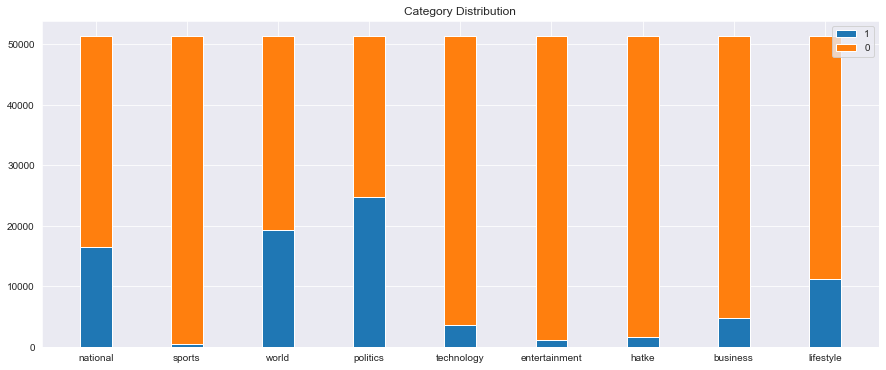

In [64]:
viz.target_multiclass_distribution(data_thewire.drop(['news', 'source'], axis=1))

# Merging and EDA

In [65]:
data = pd.concat([
    data_ani, data_indiatv, data_inshorts, data_jantakareporter, data_kaggle, data_opindia, data_postcard, data_swarajya, 
    data_tfi, data_theweek, data_thewire
], axis=0).reset_index(drop=True)
data.dropna(subset=['news'], inplace=True)
data.fillna(0, inplace=True)
print(data.shape)
data.head()

(1086753, 11)


,news,business,entertainment,lifestyle,national,sports,technology,world,source,hatke,politics
0,"\t YouTube ‘paedophilia ring’ scandal: More than 400 channels banned California [USA], February 22 (ANI): In light of the paedophilia ring concerns by users, YouTube has reportedly banned hundreds of channels and disabled comments for content that promoted child exploitation.",0.0,0.0,0.0,0.0,0.0,1.0,0.0,ani,0.0,0.0
1,"After returning from China, Pak foreign Minister goes into s Islamabad [Pakistan], Mar 19 (ANI): Pakistan foreign minister Shah Mehmood Qureshi has decided to self- quarantine himself for at least five days as a precautionary measure upon returning from an official visit to China.",0.0,0.0,0.0,0.0,0.0,0.0,1.0,ani,0.0,0.0
2,"BMW Group India Resumes Local Production at Plant Chennai Chennai (Tamil Nadu) [India], May 7 (ANI/BusinessWire India): BMW Group India started operations at Plant Chennai today in accordance with guidelines issued by local authorities.",1.0,0.0,0.0,0.0,0.0,0.0,0.0,ani,0.0,0.0
3,"FM Sitharaman's pre-budget meeting underway with Social Sector New Delhi [India], June 14 (ANI): A pre-budget meeting of Union Finance Minister Nirmala Sitharaman with the representatives of Social Sector Groups is underway here.",0.0,0.0,0.0,1.0,0.0,0.0,0.0,ani,0.0,0.0
4,"UPPSC paper leak case: Yogi accuses Akhilesh of brewing corrup Lucknow (Uttar Pradesh) [India], June 2 (ANI): Uttar Pradesh Chief Minister Yogi Adityanath on Sunday slammed Samajwadi Party and said the syndicate involved in UPPSC paper leak grew under the corrupt regime of former state chief Akhilesh Yadav.",0.0,0.0,0.0,1.0,0.0,0.0,0.0,ani,0.0,0.0


In [66]:
data[data.columns.drop(['news', 'source'])].sum()

business          65752.0
entertainment    138073.0
lifestyle        122638.0
national         352184.0
sports            94977.0
technology        42908.0
world            127212.0
hatke             55421.0
politics         144988.0
dtype: float64

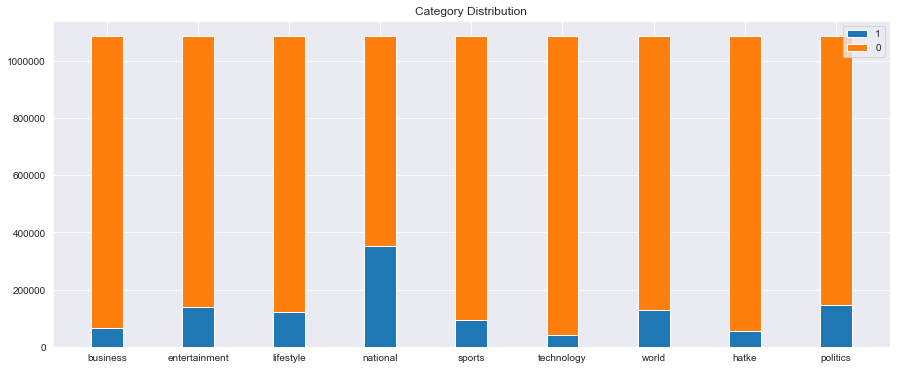

In [67]:
viz.target_multiclass_distribution(data.drop(['news', 'source'], axis=1))

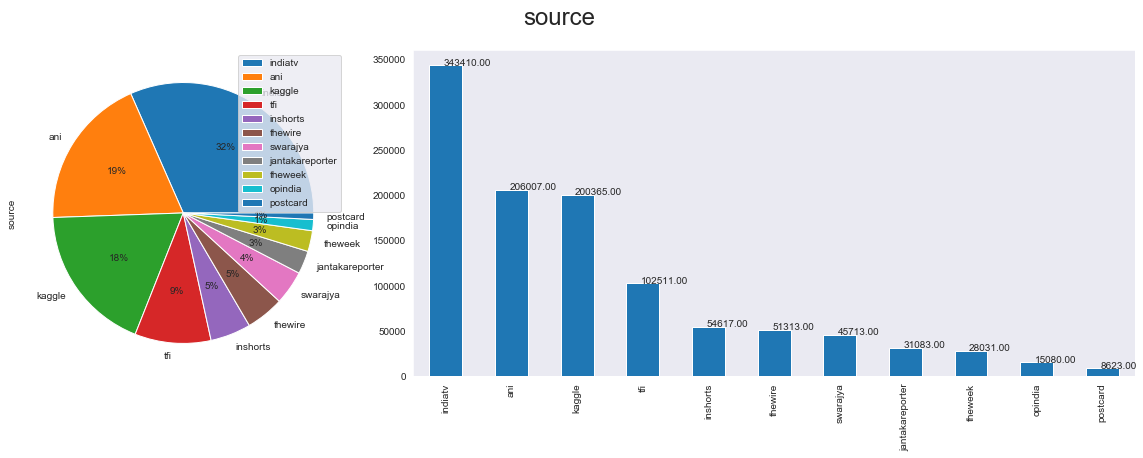

In [68]:
viz.univariate_categorical(data, 'source')

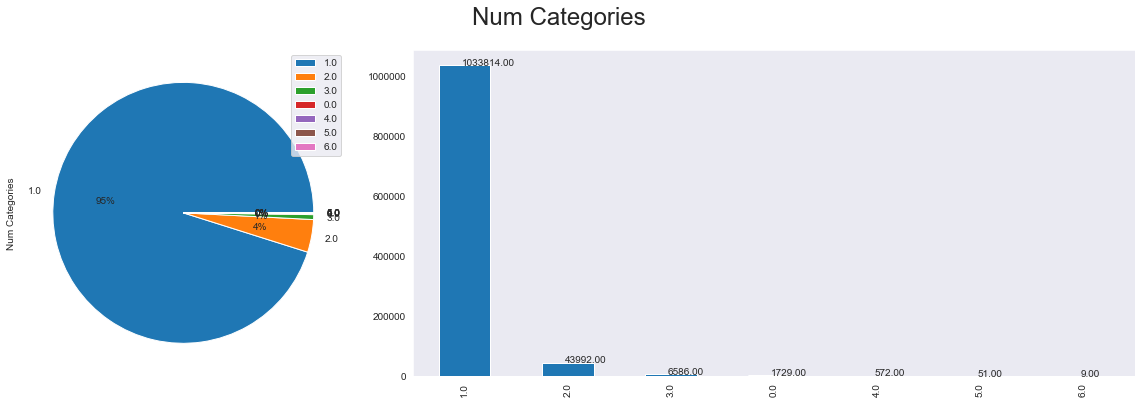

In [69]:
categories = pd.DataFrame(data[data.columns.drop(['news', 'source'])].sum(axis=1), columns=['Num Categories'])
viz.univariate_categorical(categories, 'Num Categories')

In [70]:
del data_ani, data_indiatv, data_inshorts, data_jantakareporter, data_kaggle, data_opindia, data_postcard, data_swarajya, data_tfi, data_theweek, data_thewire

## Visualizing most common words

In [71]:
labels = data.columns.drop(['news', 'source'])

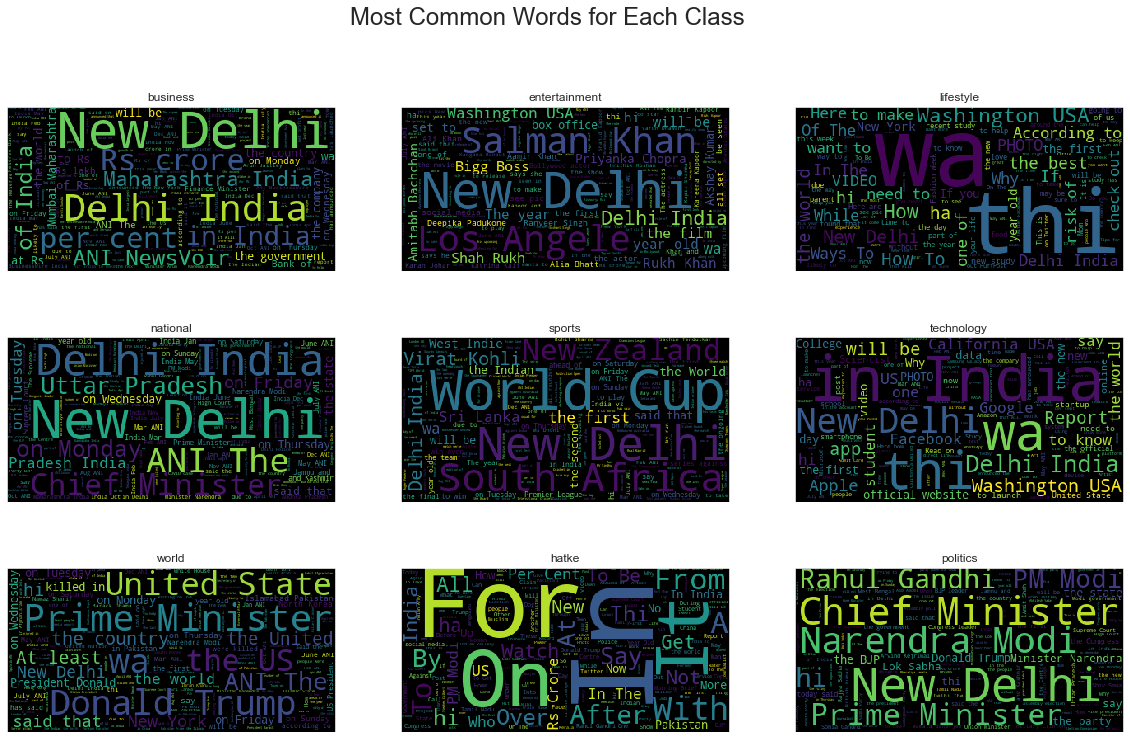

In [72]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
fig.suptitle('Most Common Words for Each Class', fontsize=24)
 
for i, col in enumerate(labels):
    ax[i//3][i%3].imshow(WordCloud().generate_from_text(' '.join(data[data[col] == 1]['news'].values)))
    ax[i//3][i%3].set_title(col)
    ax[i//3][i%3].xaxis.set_visible(False)
    ax[i//3][i%3].yaxis.set_visible(False)

## Text Cleaning


In [73]:
cleaner = TextCleaner()
data['news_clean'] = cleaner.fit_transform(data['news'].values)
data.drop(['news'], axis=1, inplace=True)
data.head()

,business,entertainment,lifestyle,national,sports,technology,world,source,hatke,politics,news_clean
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,ani,0.0,0.0,youtube paedophilia ring scandal channel banned california usa february ani light paedophilia ring concern user youtube reportedly banned hundred channel disabled comment content promoted child exploitation
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,ani,0.0,0.0,returning china pak foreign minister go islamabad pakistan mar ani pakistan foreign minister shah mehmood qureshi decided self quarantine least five day precautionary measure upon returning official visit china
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ani,0.0,0.0,bmw group india resume local production plant chennai chennai tamil nadu india may ani businesswire india bmw group india started operation plant chennai today accordance guideline issued local authority
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,ani,0.0,0.0,sitharaman pre budget meeting underway social sector new delhi india june ani pre budget meeting union finance minister nirmala sitharaman representative social sector group underway
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,ani,0.0,0.0,uppsc paper leak case yogi accuses akhilesh brewing corrup lucknow uttar pradesh india june ani uttar pradesh chief minister yogi adityanath sunday slammed samajwadi party said syndicate involved uppsc paper leak grew corrupt regime former state chief akhilesh yadav


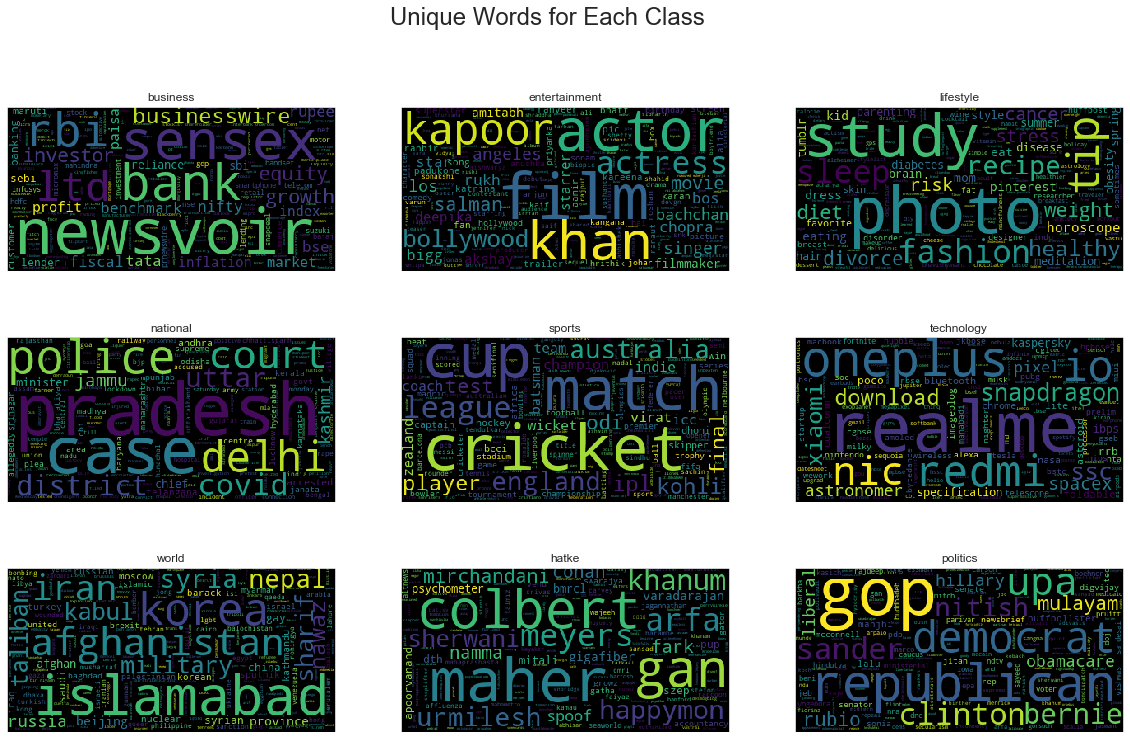

In [74]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
fig.suptitle('Unique Words for Each Class', fontsize=24)
    
for i, col in enumerate(labels):
    u = Counter(' '.join(data[data[col] == 0]['news_clean'].values).split())
    a = Counter(' '.join(data[data[col] == 1]['news_clean'].values).split())
    ax[i//3][i%3].imshow(WordCloud().generate_from_frequencies(a-u))
    ax[i//3][i%3].set_title(col)
    ax[i//3][i%3].xaxis.set_visible(False)
    ax[i//3][i%3].yaxis.set_visible(False)

## Saving

In [75]:
data['news_clean'].to_csv('../data/Xnews.csv', index=False)
data.drop(['news_clean', 'source'], axis=1).astype(int).to_csv('../data/ynews.csv', index=False)